# Implementing VoxelNet

Implementation details, I referenced the following:

1. https://github.com/baudm/VoxelNet-Keras/blob/master/model.py (MIT license)
2. https://github.com/steph1793/Voxelnet/blob/master/model.py (GPL license)
3. https://github.com/qianguih/voxelnet (No license)

I made some mistakes in the previous notebook. Rather than delete (or make difficult-to-access by putting it behind Git), I am simply putting it here :)

In [1]:
    import numpy as np
    import pandas as pd

    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import backend as K

---

# 1. Feature learning network

TODO, this is the hardest part.

---

# 2. Convolutional Middle Layers

First, let's use the notation as above:

| `ConvMD(c_in, c_out, k, s, p)` | Meaning |
| - | - |
| `M` | Dimension (i.e. 2, 3) |
| `c_in`   | Input channels 
| `c_out`  | Output channels 
| `k`      | Kernel size, size `M`, where `k = (k, k, k,)` when sizes across dimensions are the same. 
| `s` | Stride
| `p` | Padding

Per section 2.1.2, each convolutional middle layer:

1. Applies 3D convolution,
2. Batchnorm,
3. ReLU

This is described better in section 3.

Specifically, for both car and pedestrian detection, the middle layers are sequentially:

1. Conv3D(128, 64, 3, (2,1,1), (1,1,1)),
2. Conv3D(64, 64, 3, (1,1,1), (0,1,1)), 
3. Conv3D(64, 64, 3, (2,1,1), (1,1,1)),
4. yielding a 4D tensor of size 64 × 2 × 400 × 352.

In [2]:
class ConvMiddleLayer(keras.layers.Layer):
    '''
    See section 2.1.2 "Convolutional Middle Layers" of the VoxelNet paper.
    
    For parameters kk, ss, and pp, these are vectors of size MM,
    but can be instantiated as a scalar.
    
    (E.g. for MM = 3 and kk = 2, this code changes it to kk = (2, 2, 2)
    
    :param MM: Dimension of the convolution, default 3
    :type MM: int
    :param c_in: Number of input channels
    :type c_in: int
    :param c_out: Number of output channels
    :type c_out: int
    :param kk: Kernel size, vector of size MM
    :type kk: tuple or int
    :param ss: Stride size, vector of size MM
    :type ss: tuple or int
    :param pp: Padding size, vector of size MM
    :type pp: tuple or int
    :param name: Suffix of names to be given to layers
    :type name: str
    '''
    
    def __init__(
        self,
        MM = 3,
        c_in = 64,
        c_out = 64,
        kk =  3,
        ss = (2, 1, 1),
        pp = (1, 1, 1),
        name = "ConvMiddleBlock"
    ):
        
        super(ConvMiddleLayer, self).__init__(name=name)

        # Check all values first
        # (todo: type hint, how to do iterables and union in 3.7?)
        # (todo: consider using pattern matching, if you're willing to break for old python version)

        if not isinstance(MM, int):
            raise TypeError("MM must be int")
        if not isinstance(c_in, int):
            raise TypeError("c_in must be int")
        if not isinstance(c_out, int):
            raise TypeError("c_out must be int")
        
        self.MM = MM
        self.c_in = c_in
        self.c_out = c_out

        if type(kk) is int:
            self.kk = [kk for _ in range(MM)]
        elif not hasattr(kk, '__iter__'):
            raise TypeError("kk must be int or iterable of ints")
        else:
            if not len(kk) == MM:
                raise ValueError("kk must be of length MM")
            for val in kk:
                if not isinstance(val, int):
                    raise TypeError("kk must be int or iterable of ints")
            self.kk = kk

        if type(ss) is int:
            self.ss = [ss for _ in range(MM)]
        elif not hasattr(ss, '__iter__'):
            raise TypeError("ss must be int or iterable of ints")
        else:
            if not len(ss) == MM:
                raise ValueError("ss must be of length MM")
            for val in ss:
                if not isinstance(val, int):
                    raise TypeError("ss must be int or iterable of ints")
            self.ss = ss

        if type(pp) is int:
            self.pp = [pp for _ in range(MM)]
        elif not hasattr(pp, '__iter__'):
            raise TypeError("pp must be int or iterable of ints")
        else:
            if not len(pp) == MM:
                raise ValueError("pp must be of length MM")
            for val in pp:
                if not isinstance(val, int):
                    raise TypeError("pp must be int or iterable of ints")
            self.pp = pp
        
        # TODO: define data format in padding and conv layers?
        if MM == 3:
            self.pad_layer  = keras.layers.ZeroPadding3D(
                padding = self.pp,
                name = f"{self.name}_padding"
            )
            self.conv_layer = keras.layers.Conv3D(
                filters     = self.c_out,
                kernel_size = self.kk,
                strides     = self.ss,
                padding     = "valid",  # TODO: Padding self.pp applies during call
                name        = f"{self.name}_conv"
            )
        elif MM == 2:
            self.pad_layer  = keras.layers.ZeroPadding2D(
                padding = self.pp,
                name = f"{self.name}_padding"
            )
            self.conv_layer = keras.layers.Conv2D(
                filters     = self.c_out,
                kernel_size = self.kk,
                strides     = self.ss,
                padding     = "valid",  # TODO: Padding self.pp applies during call
                name        = f"{self.name}_conv"
            )
        elif MM == 1:
            self.pad_layer  = keras.layers.ZeroPadding1D(
                padding = self.pp,
                name = f"{self.name}_padding"
            )
            self.conv_layer = keras.layers.Conv1D(
                filters     = self.c_out,
                kernel_size = self.kk,
                strides     = self.ss,
                padding     = "valid",  # TODO: Padding self.pp applies during call
                name        = f"{self.name}_conv"
            )
        elif MM == 4:
            raise NotImplementedError("4D convolutions not supported! Implement this in ConvMiddleLayer.")
        else:
            raise ValueError("Dimension MM must be 1, 2, or 3..")
        
        self.batchnorm_layer = keras.layers.BatchNormalization(
            name = f"{self.name}_batchnorm"
        )
        
        self.relu_layer = keras.layers.ReLU(
            name = f"{self.name}_relu"
        )
        
    def call(
        self,
        tf_input
    ):
        if not tf_input.shape[-1] == self.c_in:
            print(f"Warning, {self.name} expected input with {self.c_in} channels, got {tf_input.shape[-1]} instead.")
        
        h1 = self.pad_layer(tf_input)
        h2 = self.batchnorm_layer(h1)
        h3 = self.relu_layer(h2)
        
        return h3

In [3]:
# Let's play around
inlayer = keras.Input(shape=(28, 28, 28, 3), batch_size=16)
conv = ConvMiddleLayer()
conv(inlayer).shape

Warning, ConvMiddleBlock expected input with 64 channels, got 3 instead.


TensorShape([16, 30, 30, 30, 3])

In [4]:
# Test input
random_input = tf.convert_to_tensor(
    np.random.random(conv.input_shape).astype(np.float32)
)

some_output = conv(random_input)

print(some_output.shape)

Warning, ConvMiddleBlock expected input with 64 channels, got 3 instead.
(16, 30, 30, 30, 3)


Warning, ConvMiddleBlock expected input with 64 channels, got 3 instead.


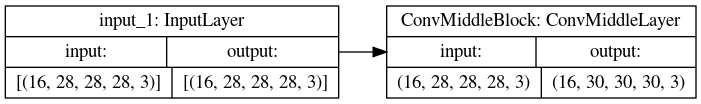

In [5]:
# Instantiate a model and plot it
model = keras.Model(inputs = inlayer, outputs = conv(inlayer))
keras.utils.plot_model(model, show_shapes=True, expand_nested=True, rankdir='LR')

# 3. Region Proposal Network

This work uses a modified version of the RPN introduced in [Faster R-CNN (Ren, He, Girshick, Sun, 2015)](https://proceedings.neurips.cc/paper/2015/file/14bfa6bb14875e45bba028a21ed38046-Paper.pdf). The RPN is defined in section 2.1.3.

The paper this same convention for Conv layers:

| `ConvMD(c_in, c_out, k, s, p)` | Meaning |
| - | - |
| `M` | Dimension (i.e. 2, 3) |
| `c_in`   | Input channels 
| `c_out`  | Output channels 
| `k`      | Kernel size, size `M`, where `k = (k, k, k,)` when sizes across dimensions are the same. 
| `s` | Stride
| `p` | Padding

Here is a summary of section 2.1.3:

1. The input to the RPN is the output from the conv middle layers.
2. The network has three blocks of several sequential fully convolutional layers:
    1. The first layer in the stack has stride of two, and the rest are stride 1.
    2. Each convolution is followed by batchnorm and relu.
3. The output of each block is upscaled (Deconv, aka ConvTranspose) and then concatenated.
4. The final concatenated block is mapped to two separate layers, a probabiliy score map and a regression map, used for learning.


Specifically, for car detection,

- Output from conv layers is `(64, 2, 400, 352)`
- Reshape to `(128, 400, 352)` (channel, height, width)
- Anchors `l^a = 3.9, w^a = 1.6, h^a = 1.56`
- Centered at `z^a_c = -1.0` with rotations 0 and 90 degrees
- Anchor matching criterion:
    - Negative if IoU < 0.45
    - Neutral if 0.45 <= IoU <= 0.6
    - Positive if IoU > 0.6
- The region proposal network is defined in Figure 4

And for pedestrians,

- Anchors `l^a = 0.8, w^a = 0.6, h^a = 1.73`
- Centered at `z^a_c = -0.6` with rotations 0 and 90 degrees
- Anchor matching criterion:
    - Negative if IoU < 0.35
    - Neutral if 0.35 <= IoU <= 0.50
    - Positive if IoU > 0.50
- The RPN is mostly identical to the one in Figure 4.
    - One change: Stride in the first 2D Conv is 2, not 1

---

# 3.1. Conv Block

The RPN is defined as a layer of convolution blocks. The outputs of these blocks are the transposed and concatenated (per Figure 4 in the paper). Our RPNConvBlock class defines these blocks.

In [6]:
class RPNConvBlock(keras.layers.Layer):
    '''
    See section 2.1.3 "Convolutional Middle Layers" of the VoxelNet paper.
    
    This defines a 2D convolution block used in the RPN.
    
    :param filters: Number of filters in each convolution block
    :type filters: int
    :param qq: Number of stacks of convolutions
    :type qq: int
    :param kernel_size:
    :type kernel_size:
    :param get_strides: A function mapping integers [0, ..., q) to integers.
        (By default, follows values for car detection. Use `lambda ii: 1` to return constant 1.)
    :type strides: function
    :param padding: 
    :type padding: 
    :param name: Suffix of names to be given to layers
    :type name: str
    '''
    
    def __init__(
        self,
        qq      = 6,
        filters = 128,
        kernel_size = 3,
        get_strides = lambda ii: 2 if ii == 0 else 1,
        padding = 1,
        name = "RPN_Conv_Block",
    ):
        
        super(RPNConvBlock, self).__init__(name=name)
        
        if qq <= 0:
            raise ValueError(f"Expected positive number of layers, but RPN conv block \"{name}\" got qq = {qq}")
        
        self.qq = qq
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.get_strides = get_strides
        self.block_layers = []
        
        for ii in range(self.qq):
            strides = self.get_strides(ii)
            
            new_layers = [
                keras.layers.ZeroPadding2D(
                    padding = self.padding,
                    name = f"{self.name}_zeropadding_{ii}"
                ),
                keras.layers.Conv2D(
                    filters = self.filters,
                    kernel_size = self.kernel_size,
                    strides = strides,
                    padding = 'valid',
                    name = f"{self.name}_conv_{ii}"   
                ),
                keras.layers.BatchNormalization(
                    name = f"{self.name}_bn_{ii}"
                ),
                keras.layers.ReLU(
                    name = f"{self.name}_relu_{ii}"
                )
            ]
            
            
            self.block_layers.extend(new_layers)
        
    def call(
        self,
        xx
    ):
        for layer in self.block_layers:
            xx = layer(xx)
        
        return xx
        


In [7]:
# Let's play around
# E.g. D' = 10, H' = 20, W' = 24
# TODO: Unsure if this is the right order
inlayer = keras.Input(shape=(20, 24, 128), batch_size=1)
conv = RPNConvBlock()
conv(inlayer).shape

TensorShape([1, 10, 12, 128])

In [8]:
# Test input
random_input = tf.convert_to_tensor(
    np.random.random(conv.input_shape).astype(np.float32)
)
some_output = conv(random_input)

print(some_output.shape)


(1, 10, 12, 128)


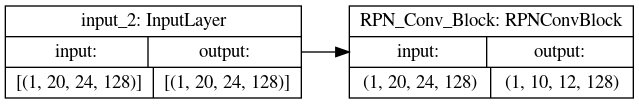

In [9]:
# Instantiate a model and plot it
model = keras.Model(inputs = inlayer, outputs = conv(inlayer))
keras.utils.plot_model(model, show_shapes=True, expand_nested=True, rankdir='LR')

## 3.2. Connecting them with Deconv blocks

Deconv2D is also known as Conv2DTranspose. Keras defines the following:


```
tf.keras.layers.Conv2DTranspose(
    filters,
    kernel_size,
    strides=(1, 1),
    padding="valid",
    output_padding=None,
    data_format=None,
    dilation_rate=(1, 1)
)
```

For block 1, 2, 3 respectively, the paper uses these:

`                 flt, k, s, p`
1. `Deconv2D(128, 256, 3, 1, 0)`
2. `Deconv2D(128, 256, 2, 2, 0)`
3. `Deconv2D(256, 256, 4, 4, 0)

Fllowing the parameters in the paper, these should be `filters in, filters out, kernel size, strides, padding`, respectively.

**This is simple enough to do, but I am low on RAM. Let me show you an example here with a very small input size.**

In [10]:
# H = 8, W = 16. (todo: might be swapped.) Using 16 instead of 128
input_shape = (8, 16, 32) #(200, 240, 128)

inlayer = keras.Input(shape=input_shape, batch_size=1)

# rpn conv blocks
rpn_block_1 = RPNConvBlock(qq = 4, name = 'rpn_block_1')(inlayer)
rpn_block_2 = RPNConvBlock(qq = 6, name = 'rpn_block_2')(rpn_block_1)
rpn_block_3 = RPNConvBlock(qq = 6, name = 'rpn_block_3')(rpn_block_2)

# deconv blocks
rpn_deconv_1 = keras.layers.Conv2DTranspose(
    filters = 256, kernel_size = 3, strides = 1, padding = 'same', name = 'rpn_deconv_1'
)(rpn_block_1)
rpn_deconv_2 = keras.layers.Conv2DTranspose(
    filters = 256, kernel_size = 2, strides = 2, padding = 'same', name = 'rpn_deconv_2'
)(rpn_block_2)
rpn_deconv_3 = keras.layers.Conv2DTranspose(
    filters = 256, kernel_size = 4, strides = 4, padding = 'same', name = 'rpn_deconv_3'
)(rpn_block_3)



## 3.3. Stack deconv layers, and output to learning targets

After stacking the deconv layers to (again, see Fig 4), we then output two two different learning targets.

In [11]:
deconv_layers = [rpn_deconv_1, rpn_deconv_2, rpn_deconv_3]

for deconv_layer in deconv_layers:
    print(deconv_layer.shape)

# concatenate the 3 deconv blocks
rpn_penultimate = keras.layers.Concatenate(name = 'rpn_penultimate')(deconv_layers)

print(rpn_penultimate.shape)

(1, 4, 8, 256)
(1, 4, 8, 256)
(1, 4, 8, 256)
(1, 4, 8, 768)


In [12]:
# Two outputs

probability_score_map = keras.layers.Convolution2D(
    filters = 2,
    kernel_size = 1,
    name = "RPN_prob_score_map",
)(rpn_penultimate)

regression_map = keras.layers.Convolution2D(
    filters = 14,
    kernel_size = 1
)(rpn_penultimate)

## 3.4. Let's play around with this.

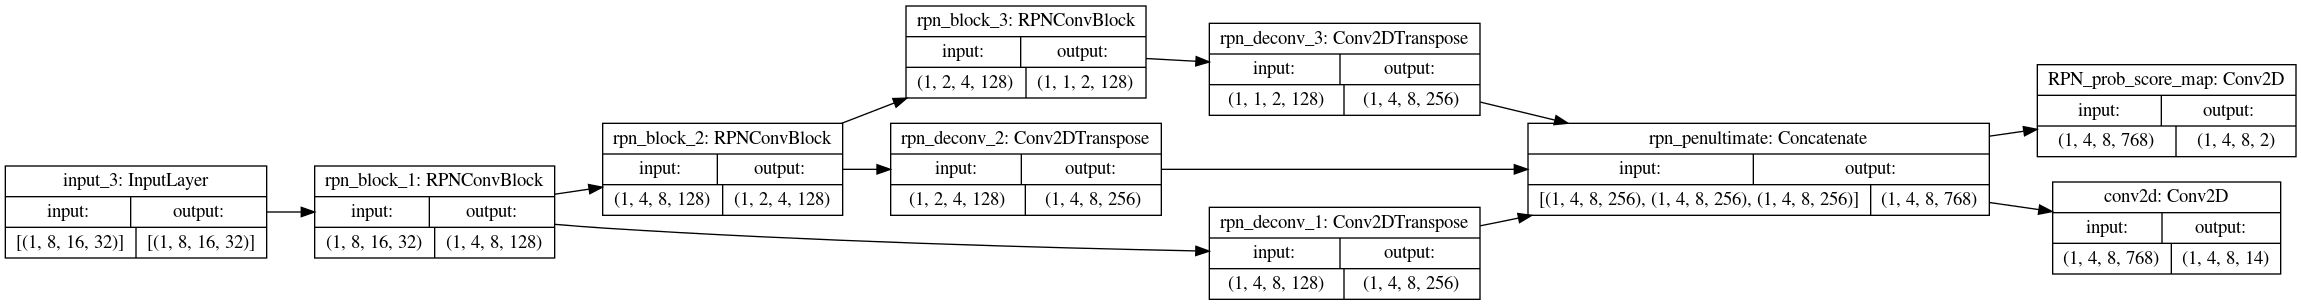

In [13]:
# Instantiate a model and plot it
model = keras.Model(inputs = inlayer, outputs = [probability_score_map, regression_map])
keras.utils.plot_model(model, show_shapes=True, expand_nested=True, rankdir='LR')

# This is what we expect, even if it's very ugly.

---

# 4. Loss function

The paper defines loss in section 2.2. as follows:

- Let $\{a_i^{pos}\}{_{i=1 ... N_{pos}}}$ be the set of $N_{pos}$ positive anchors.
- Let $\{a_i^{neg}\}{_{i=1 ... N_{neg}}}$ be the set of $N_{neg}$ negative anchors.
- Parameterize a 3D ground truth box as $(x_c^g, y_c^g, y_c^g, l^g, w^g, h^g, \theta^g)$, where
    - $x_c^g, y_c^g, y_c^g$ is the center location,
    - $l^g, w^g, h^g$ are the bounding box extents,
    - $\theta^g$ is the yaw rotation around the Z axis.
- Let residual $\mathbf{u}^* \in \mathbb{R}^7 = (\Delta x, \Delta y, \Delta z, \Delta l, \Delta w, \Delta h, \Delta \theta)$

These residuals are defined as:

$$
\begin{align}
\Delta x & = \frac{x^g_c - x^a_c}{d^a} \\
\Delta y & = \frac{y^g_c - y^a_c}{d^a} \\
\Delta z & = \frac{z^g_c - z^a_c}{h^a} \\
\Delta l & = \log \left( \frac{l^g}{l^a} \right )\\
\Delta w & = \log \left( \frac{w^g}{w^a} \right )\\
\Delta h & = \log \left( \frac{h^g}{h^a} \right )\\
\Delta \theta & = \theta^g - \theta^a
\end{align}
$$

where $d^a = \sqrt{\left(l^a\right)^2 + \left(w^a\right)}$ be the diagonal of the base of the anchor box.

The loss is then defined as follows:

$$
\begin{align}
L & = \alpha\frac{1}{N_{pos}} L_{cls}\left(p_i^{pos}, 1\right) \\
  & + \beta\frac{1}{N_{neg}} L_{cls}\left(p_j^{neg}, 0\right) \\
  & + \frac{1}{N_{pos}} L_{reg}(\mathbf{u}_i, \mathbf{u}^*_i)
\end{align}
$$

Here,
 - $\alpha$ and $\beta$ are positive constants balancing the relative importance.
     - For car detection, we have $(\alpha, \beta) = (1.5, 1.0)$.
     - For pedestrian detection, we have $(\alpha, \beta) = (1.5, 1.0)$.
 - $p_i^{pos}$ and $p_j^{neg}$ are the softmax output for the positive anchors $a_i^{pos}$ and $a_j^{neg}$
 - We have $\mathbf{u}_i$ and $\mathbf{u}^*_i$ as the regression output and ground truth for positive anchor $a_i^{pos}$
 - The first term is the normalized classification loss for $\{a_i^{pos}\}{_{i=1 ... N_{pos}}}$
 - The second term is the normalized classification loss for $\{a_i^{neg}\}{_{i=1 ... N_{neg}}}$
 - $L_{cls}$ is the binary cross entropy loss
 - $L_{reg}$ is regression loss, using the **SmoothL1** function.

---

# 5. Training

Training uses SGD, learing rate 0.01 for the first 150 epochs, decreased to 0.001 for the last 10 epochs. Batch size of 16.